In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (100,100,100),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=5.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=30, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=3)

pos = 0.7

# test_phantom.add_tissue_sphere((pos,-pos,0), 2, blood)
# test_phantom.add_tissue_sphere((pos,0,0), 4, blood)
# test_phantom.add_tissue_sphere((pos,pos,0), 8, blood)

# test_phantom.add_tissue_sphere((-pos,-pos,0), 4, fat)
# test_phantom.add_tissue_sphere((-pos,0,0), 8, fat)
# test_phantom.add_tissue_sphere((-pos,pos,0), 2, fat)

# test_phantom.add_tissue_sphere((0,-pos,0), 8, myocardium)
# test_phantom.add_tissue_sphere((0,0,0), 2, myocardium)
# test_phantom.add_tissue_sphere((0,pos,0), 4, myocardium)

test_phantom.add_tissue_sphere((0,0,0), 4, myocardium)


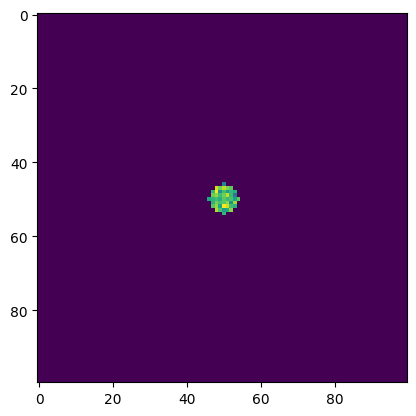

In [3]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [4]:
transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 32, 
                                    width = 20e-3,
                                    height =  20e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/2,
                                    ray_num = 16, 
                                    imaging_ndims = 2,
                                    focus_elevation = 20e-3,
                                    ) for i in range(3)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

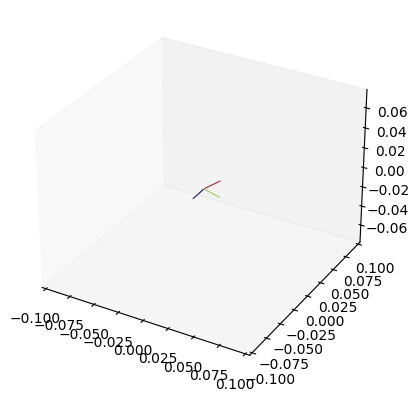

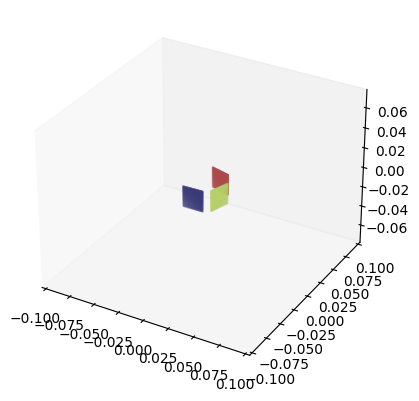

In [5]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
test_transducer_set.generate_extrinsics(shape="spherical", extrinsics_kwargs={'r_mean': 20e-3, 'view_std': 0, 'yaw_fraction': 1, 'pitch_fraction': 0, 'roll_fraction': 0})
test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [6]:
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='pressure_field')
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [7]:
simprops = simulation.SimProperties(
                grid_size   = (65e-3,60e-3,20e-3),
                voxel_size  = (0.1e-3,0.1e-3,0.1e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [8]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/planewave_test_01',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = ['p_max']
                 )

test_experiment.save()

In [9]:
# test_experiment.plot_ray_path(4)

In [10]:
test_experiment = experiment.Experiment.load('../experiment_files/planewave_test_01')
test_experiment.run(dry=True)

Number of simulation results (24) is less than the expected number of simulation results (48), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 3/3 [00:00<00:00,  5.51it/s]


In [ ]:
test_experiment.run(repeat=True)

In [12]:
test_experiment.add_results()

In [13]:
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

100%|██████████| 48/48 [01:27<00:00,  1.82s/it]


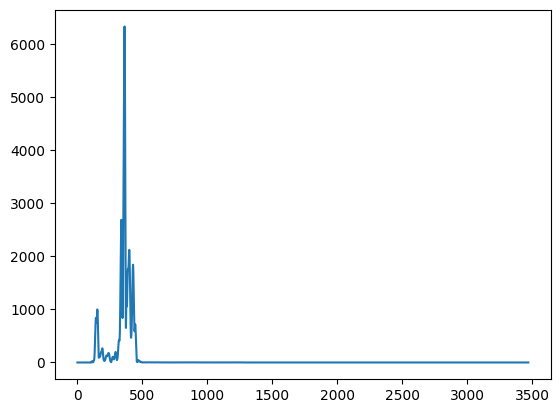

In [14]:
image = test_reconstruction.compound()

In [15]:
image.shape

(34, 34, 34)

In [16]:
test_reconstruction.results[0][1]

array([[ 0.00000000e+00,  1.22270649e-04, -2.35420302e-03, ...,
         2.42073154e+00,  1.45643425e+00, -1.42833637e-02],
       [ 0.00000000e+00,  2.86312820e-06,  1.90039391e-05, ...,
         7.04738021e-01, -9.37003136e-01, -1.32640076e+00],
       [ 0.00000000e+00,  1.22233847e-04, -2.36233324e-03, ...,
         1.65979958e+00,  1.30062103e+00,  5.27373433e-01],
       ...,
       [ 0.00000000e+00, -8.43614120e+01, -3.85419800e+02, ...,
         2.20715356e+00, -9.76580858e-01, -3.10386229e+00],
       [ 0.00000000e+00,  2.00003870e-02,  3.75573575e-01, ...,
        -2.60901117e+00, -2.23398948e+00,  2.28899255e-01],
       [ 0.00000000e+00, -8.42797699e+01, -3.84630035e+02, ...,
         2.50066614e+00, -1.51703811e+00, -3.90546536e+00]])

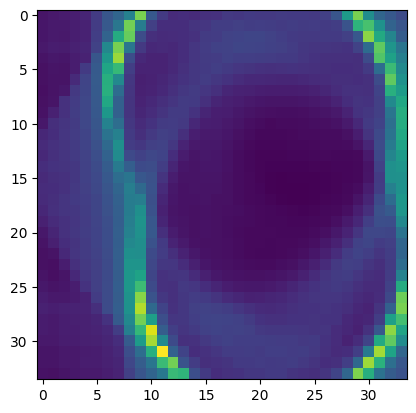

In [17]:
plt.imshow(image[:,:,image.shape[2]//2])

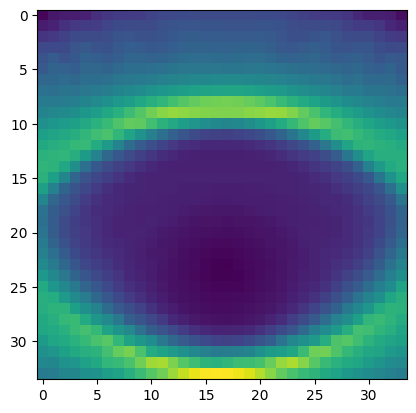

In [18]:
plt.imshow(image[image.shape[0]//2,:,:])

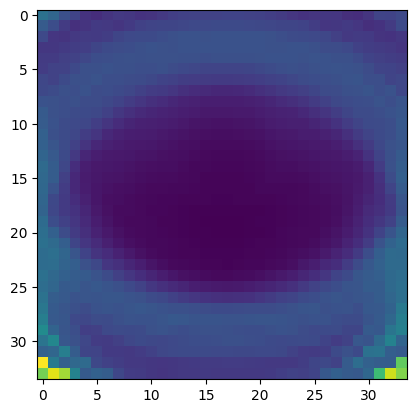

In [19]:
plt.imshow(image[:,image.shape[1]//2,:])

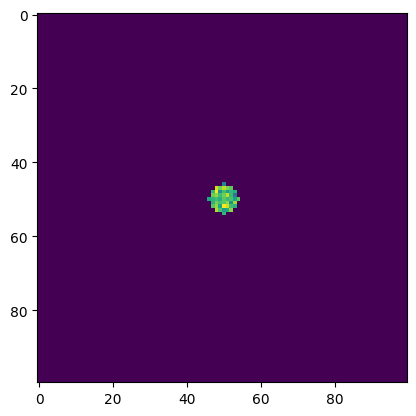

In [20]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])